In [55]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime

视频分类，涉及推荐、安全等应用程序。我们将使用 ucf101数据集来构建我们的视频分类器。这个数据库包含了分类为不同动作的视频，比如击球、击球、骑自行车等。此数据集通常用于构建动作识别器，这是视频分类的一个应用。

视频由一系列有序的帧组成。每个帧包含空间信息，这些帧的序列包含时间信息。为了对这两个方面建模，我们使用了一个混合体系结构，它由卷积(用于空间处理)和轮回层(用于时间处理)组成。具体来说，我们将使用一个卷积神经网络图层(CNN)和一个由 GRU 图层组成的递归神经网络图层(RNN)。这种混合结构通常被称为 CNN-RNN。

## 读取数据

In [56]:
train_df = pd.read_csv("train.csv",sep = ",",names = ['path','class'])
train_df

,path,class
0,v_ApplyEyeMakeup_g08_c01.avi,0
1,v_ApplyEyeMakeup_g08_c02.avi,0
2,v_ApplyEyeMakeup_g08_c03.avi,0
3,v_ApplyEyeMakeup_g08_c04.avi,0
4,v_ApplyEyeMakeup_g08_c05.avi,0
...,...,...
9532,v_YoYo_g25_c01.avi,100
9533,v_YoYo_g25_c02.avi,100
9534,v_YoYo_g25_c03.avi,100
9535,v_YoYo_g25_c04.avi,100


### Dense Trajectories Optical Flow in OpenCV

In [57]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture(cv.samples.findFile("/Users/fengqishun/Downloads/ucf101_standard_split_1/media/v_ApplyEyeMakeup_g01_c02.avi"))
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    cv.imshow('frame2', bgr)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png', frame2)
        cv.imwrite('opticalhsv.png', bgr)
    prvs = next
cv.destroyAllWindows()

No frames grabbed!


### 10类- 500个样品
#### 由于RAM的大小有限，我希望使用更少的类和示例来进行演示。它可能会影响性能，但在此上下文中已经足够了。

In [58]:
content = []
i = 0
n = 50
while len(content) < 10 and i < 102:
    if len(train_df[train_df['class']==i]) >= n:
        df_temp = train_df[train_df['class']==i].iloc[:n]
        path = df_temp['path']
        content.append(path)
        
    i += 1
    

content = np.array(content)

In [59]:
content = content.reshape(500,)
y = np.array([i//50 for i in range(0,500)])

In [45]:
content

array(['v_ApplyEyeMakeup_g08_c01.avi', 'v_ApplyEyeMakeup_g08_c02.avi',
       'v_ApplyEyeMakeup_g08_c03.avi', 'v_ApplyEyeMakeup_g08_c04.avi',
       'v_ApplyEyeMakeup_g08_c05.avi', 'v_ApplyEyeMakeup_g09_c01.avi',
       'v_ApplyEyeMakeup_g09_c02.avi', 'v_ApplyEyeMakeup_g09_c03.avi',
       'v_ApplyEyeMakeup_g09_c04.avi', 'v_ApplyEyeMakeup_g09_c05.avi',
       'v_ApplyEyeMakeup_g09_c06.avi', 'v_ApplyEyeMakeup_g09_c07.avi',
       'v_ApplyEyeMakeup_g10_c01.avi', 'v_ApplyEyeMakeup_g10_c02.avi',
       'v_ApplyEyeMakeup_g10_c03.avi', 'v_ApplyEyeMakeup_g10_c04.avi',
       'v_ApplyEyeMakeup_g10_c05.avi', 'v_ApplyEyeMakeup_g11_c01.avi',
       'v_ApplyEyeMakeup_g11_c02.avi', 'v_ApplyEyeMakeup_g11_c03.avi',
       'v_ApplyEyeMakeup_g11_c04.avi', 'v_ApplyEyeMakeup_g11_c05.avi',
       'v_ApplyEyeMakeup_g12_c01.avi', 'v_ApplyEyeMakeup_g12_c02.avi',
       'v_ApplyEyeMakeup_g12_c03.avi', 'v_ApplyEyeMakeup_g12_c04.avi',
       'v_ApplyEyeMakeup_g12_c05.avi', 'v_ApplyEyeMakeup_g12_c06.avi',
      

In [46]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos

In [47]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [9]:
X_frames = read_frames("/Users/fengqishun/Downloads/ucf101_standard_split_1/media/",content)
X_frames = select_frames(X_frames, 10)

99.8
(500, 10, 128, 192, 3)


In [12]:
xtr, xte, ytr , yte = train_test_split(X_frames , y , shuffle=True,test_size = 0.2,random_state = 42)

In [13]:
ytr = to_categorical(ytr, 10)
yte = to_categorical(yte,10)

## 随机样本的可视化

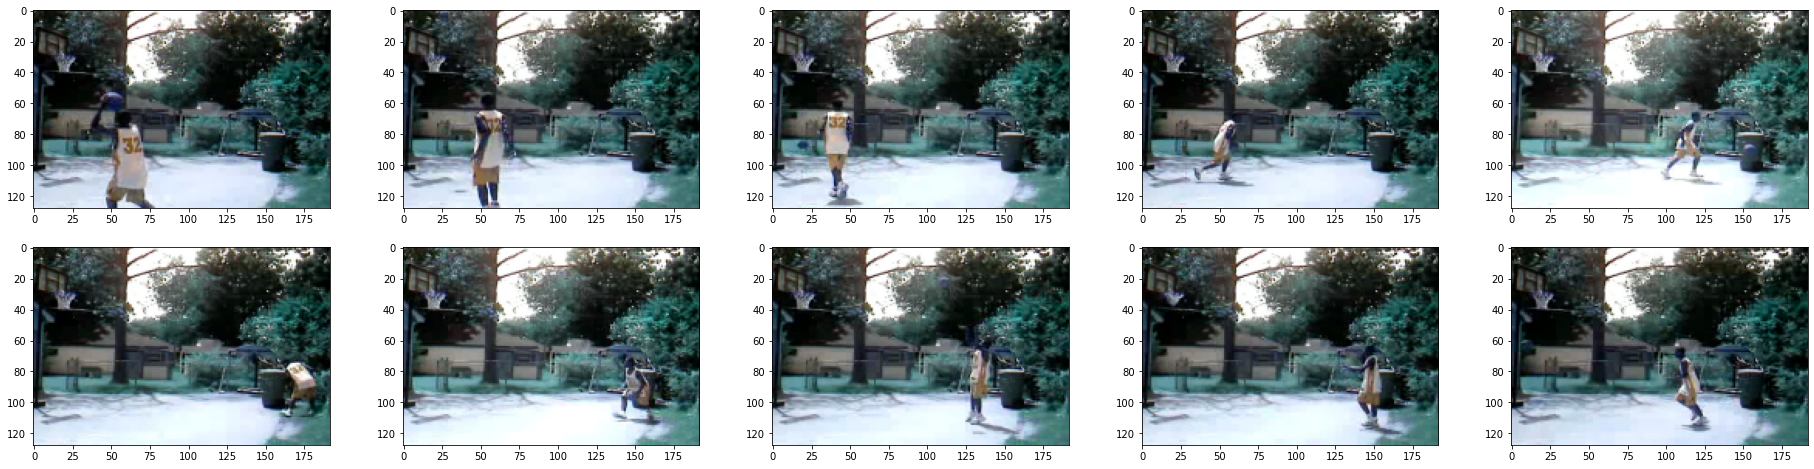

In [48]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(X_frames))

for i,image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

## 建造模型

In [49]:
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  s = tf.shape(xs)
 
  return xs

In [50]:
ish=(10, 128, 192, 3)
  
xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    
  xs.append(x)

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*48*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 128, 19  0           []                               
                                2, 3)]                                                            
                                                                                                  
 lambda_11 (Lambda)             (None, 128, 192, 3)  0           ['input_2[0][0]']                
                                                                                                  
 lambda_12 (Lambda)             (None, 128, 192, 3)  0           ['input_2[0][0]']                
                                                                                                  
 lambda_13 (Lambda)             (None, 128, 192, 3)  0           ['input_2[0][0]']          

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## 模型设计

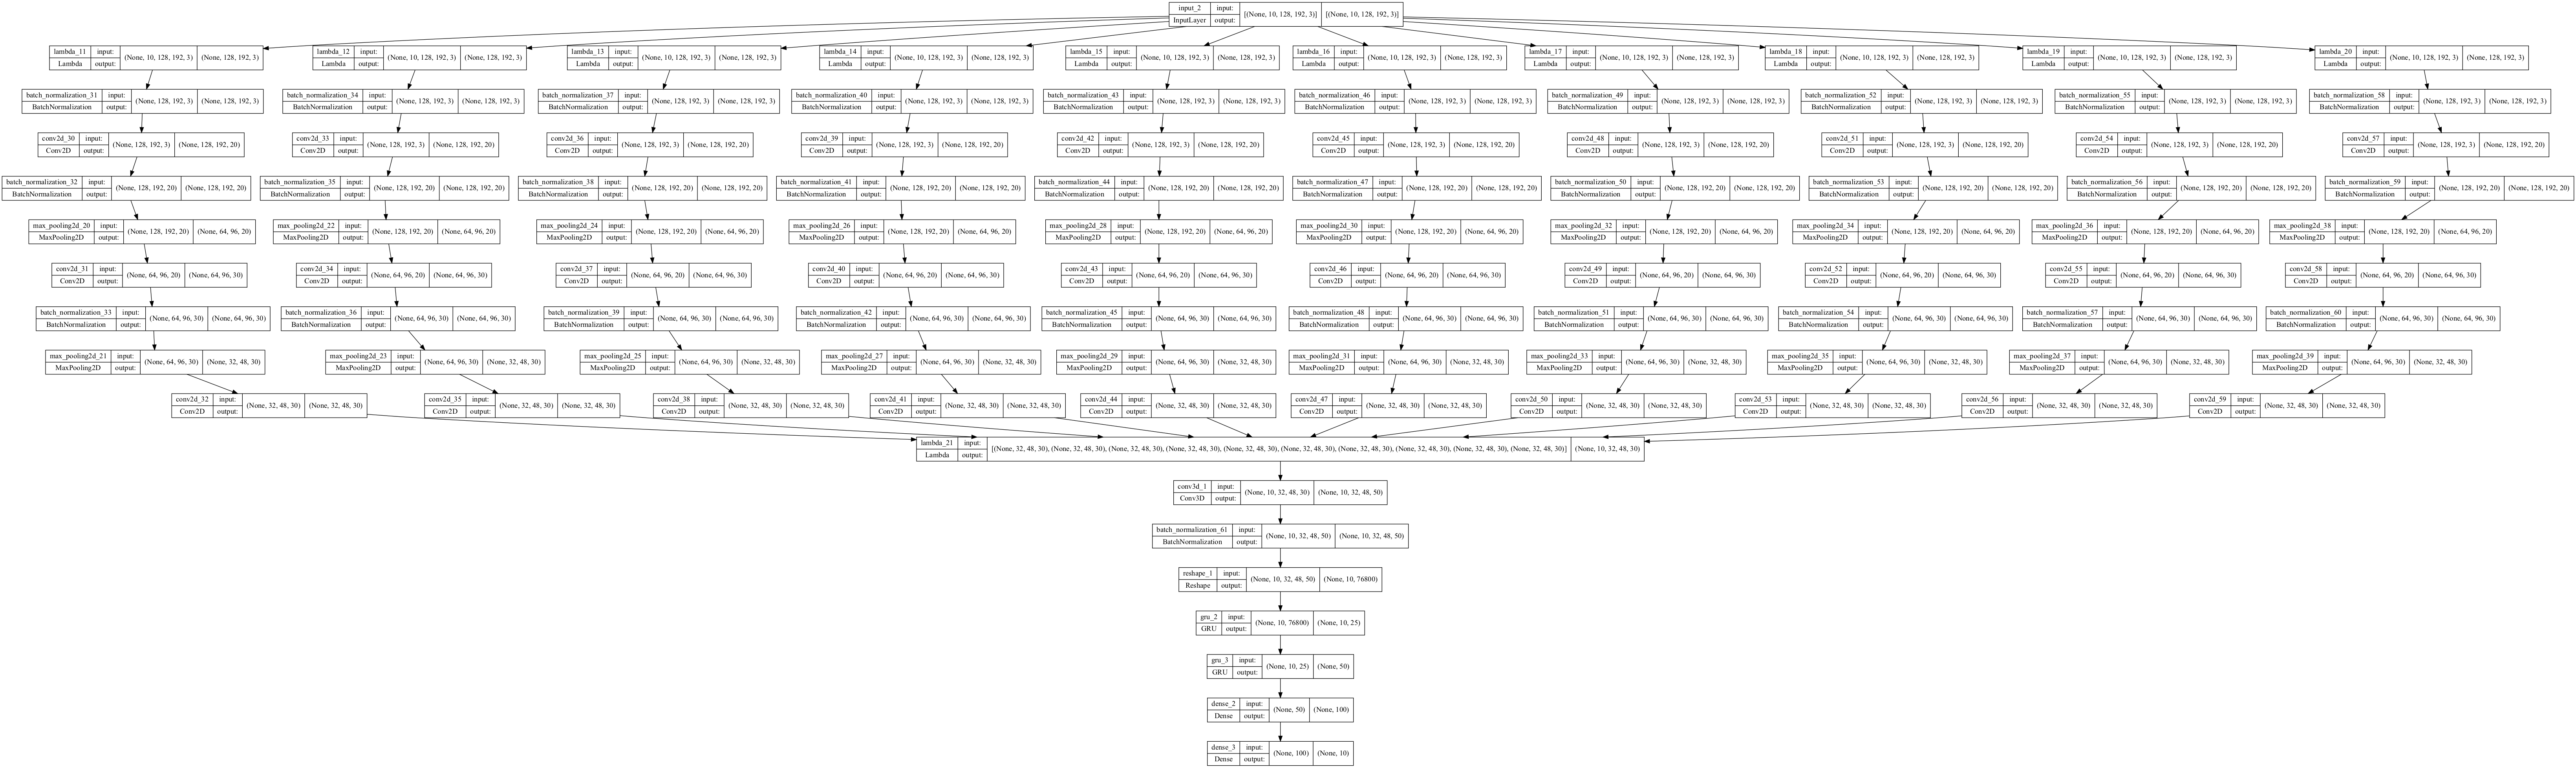

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## 训练模型

In [52]:
history = model.fit(xtr, ytr, epochs=5, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/5
40/40 [==============================] - 147s 3s/step - loss: 2.1416 - accuracy: 0.2975 - val_loss: 1.9902 - val_accuracy: 0.5600
Epoch 2/5
40/40 [==============================] - 99s 2s/step - loss: 1.8196 - accuracy: 0.6550 - val_loss: 1.7698 - val_accuracy: 0.6500
Epoch 3/5
40/40 [==============================] - 82s 2s/step - loss: 1.5603 - accuracy: 0.7875 - val_loss: 1.5242 - val_accuracy: 0.8000
Epoch 4/5
40/40 [==============================] - 107s 3s/step - loss: 1.3261 - accuracy: 0.8600 - val_loss: 1.2968 - val_accuracy: 0.8300
Epoch 5/5
40/40 [==============================] - 99s 2s/step - loss: 1.0874 - accuracy: 0.9350 - val_loss: 1.0899 - val_accuracy: 0.8800


## 模型表现

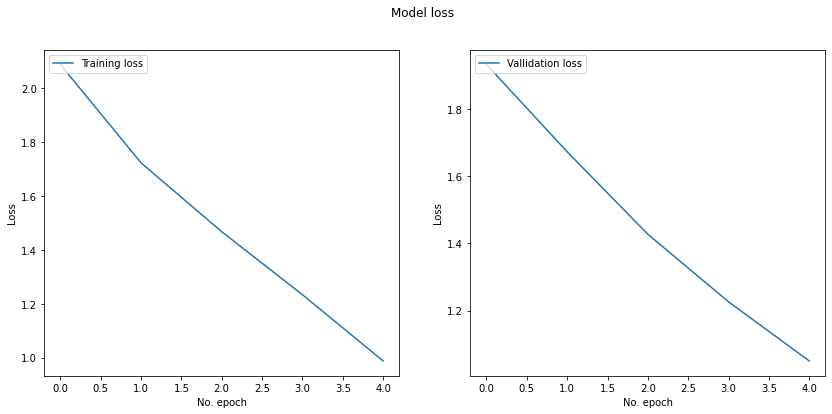

In [19]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

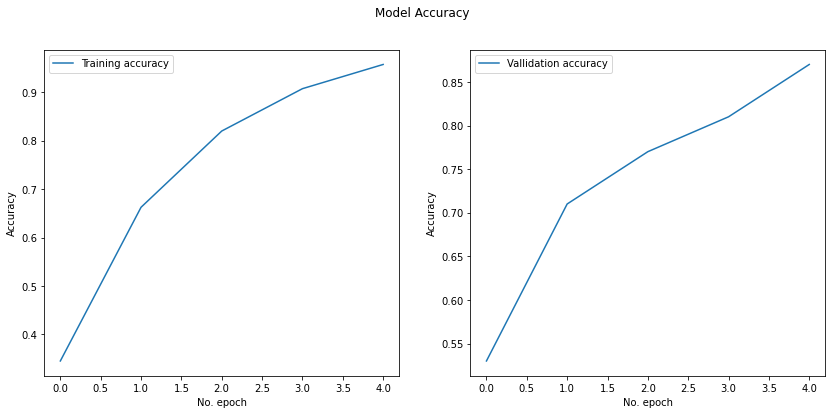

In [20]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

## 模型演示

In [22]:
classes = ['ApplyEyeMakeup','Lipstick','Archery','BabyCrawling','BalanceBeam','BandMarching','BaseballPitch','Basketball','BasketballDunk','BenchPress']

In [23]:
num_classes = [i for i in range(10)]
class_map = dict(zip(num_classes,classes))

In [24]:
class_map

{0: 'ApplyEyeMakeup',
 1: 'Lipstick',
 2: 'Archery',
 3: 'BabyCrawling',
 4: 'BalanceBeam',
 5: 'BandMarching',
 6: 'BaseballPitch',
 7: 'Basketball',
 8: 'BasketballDunk',
 9: 'BenchPress'}

In [25]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)
predicted  = np.argmax(predicted,axis=1)

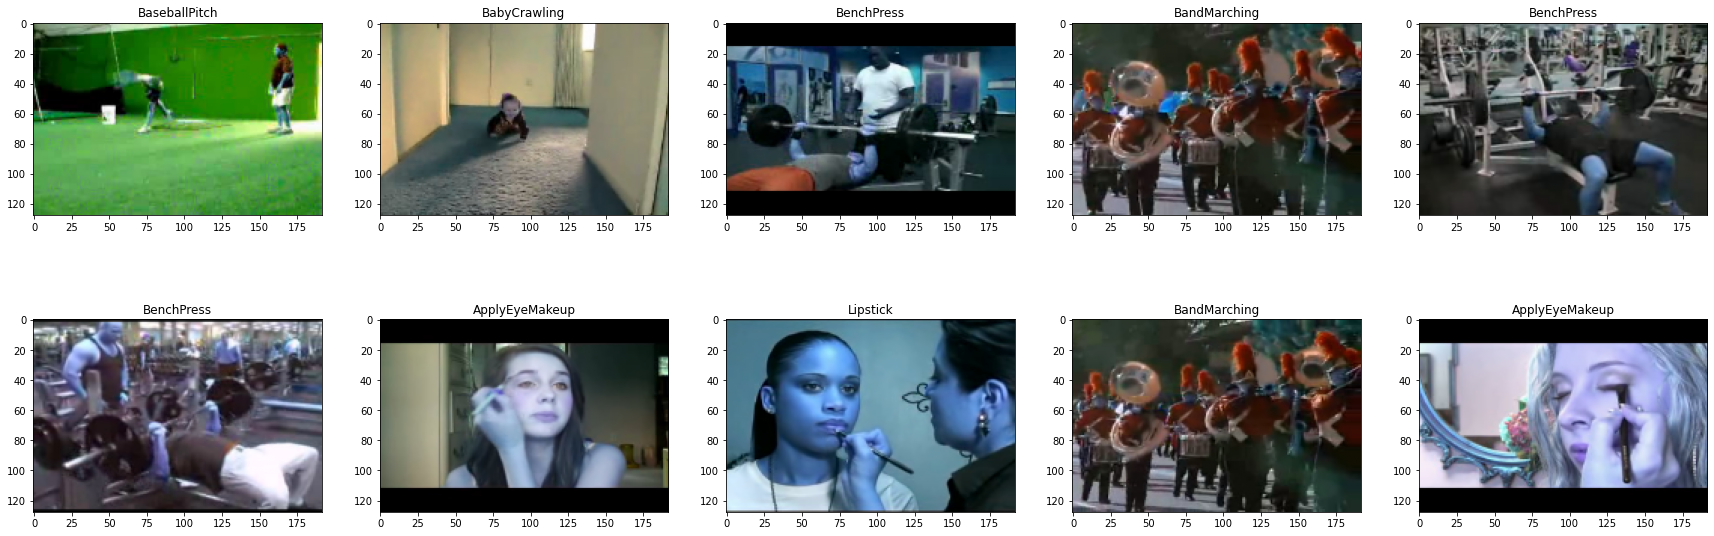

In [26]:
fig = plt.figure(figsize=(30,10))

for i,rand_indx in enumerate(random_videos):
    ax = plt.subplot(2,5,i+1)
    video = xte[rand_indx]
    frame = video[np.random.randint(0,10)]
    ax.set_title(class_map[predicted[i]])
    imshow(frame)

In [54]:
pip freeze

absl-py==0.11.0
addict==2.4.0
aiohttp==3.8.1
aiohttp-cors==0.7.0
aioredis==2.0.1
aiosignal==1.2.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.1.4
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1621348054992/work
anyio @ file:///opt/concourse/worker/volumes/live/64740ac7-3a9c-4fbb-6685-a51c4ff8b4ca/volume/anyio_1617783319350/work/dist
appdirs==1.4.4
applaunchservices==0.2.1
appnope @ file:///opt/concourse/worker/volumes/live/5f13e5b3-5355-4541-5fc3-f08850c73cf9/volume/appnope_1606859448618/work
appscript @ file:///opt/concourse/worker/volumes/live/82e8b4c7-2416-4d10-509e-144ca79d9b1d/volume/appscript_1611426996703/work
argh==0.26.2
argon2-cffi @ file:///opt/concourse/worker/volumes/live/d733ceb5-7f19-407b-7da7-a386540ab855/volume/argon2-cffi_1613037492998/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///opt/concourse/worker/volumes/live/343a8902-287c-47fb-6db8